In [1]:
import xspec
from xspec import *
import numpy as np
import matplotlib.pyplot as plot1
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.optimize import curve_fit
import os
import signal

Photon Index1: -2.201252076815153
Photon Index2: -0.9440035636616002
Ep: 0.6794795122177896

Spectrum #: 1 replaced 

1 spectrum  in use
 
Spectral Data File: /media/abhi/Data/Data/Galactic_transients/0/spec_grp_1.pi  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.098e-01 +/- 4.637e-02 (91.2 % total)
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-282
  Telescope: eROSITA Instrument: MERGED  Channel Type: PI
  Exposure Time: 209.2 sec
 Using fit statistic: chi
 Using Background File                ./en01_079066_020_BackgrSpec_00008_c010.fits
  Background Exposure Time: 209.2 sec
 Using Response (RMF) File            ./en01_079066_020_RMF_00008_c010.fits for Source 1
 Using Auxiliary Response (ARF) File  ./en01_079066_020_ARF_00008_c010.fits


Fit statistic  : Chi-Squared                 5434.63     using 282 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number: 1

Test statistic : Chi-Squared                

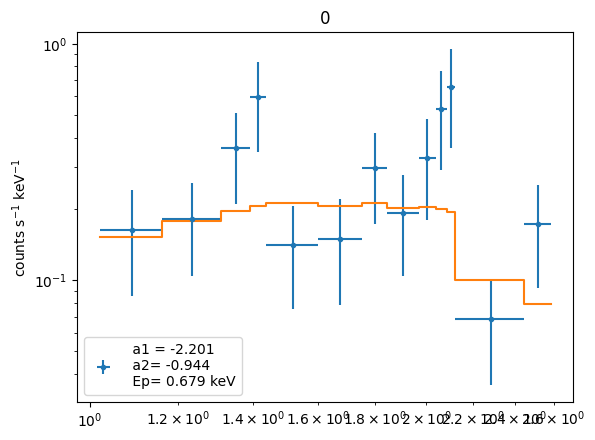

In [14]:
#Plotting all the energy spectra using the looping
base_dir = "/media/abhi/Data/Data/Galactic_transients"  
save_dir = "/home/abhi/Data/Data/Galactic_transients/All"

#Defining the exception
class TimeoutException(Exception):
    pass

def timeout_handler(signum, frame):
    raise TimeoutException()

signal.signal(signal.SIGALRM, timeout_handler)


for i in range(0,1):
    folder = os.path.join(base_dir, str(i))
    file_path = os.path.join(folder, "spec_grp_1.pi")
    plot_file = os.path.join(save_dir, f"spec_{i}.png")

    os.chdir(folder)  
    xspec.AllData(file_path)
    #xspec.Plot.device = f"{plot_file} /png"
    xspec.Plot.xAxis = "keV"
    xspec.Plot("data")
    

    try:
        #Fitting model (broken Power law) and initial parameters
        model = xspec.Model("bknpower")
        xspec.AllData.ignore("**-0.2 3.0-**")

        #initiate params
        model.bknpower.PhoIndx1 = 1
        model.bknpower.BreakE = 1
        model.bknpower.PhoIndx2 = 2
        model.bknpower.norm = 1

        #Fit
        signal.alarm(5)
        xspec.Fit.perform()
        
        # Print parameter values
        a1 = model.bknpower.PhoIndx1.values[0]
        a2 = model.bknpower.PhoIndx2.values[0]
        Ep = model.bknpower.BreakE.values[0]
        print("Photon Index1:", a1)
        print("Photon Index2:", a2)
        print("Ep:", Ep)

        
        #Plotting
        Plot("ldata chi")
        energies = Plot.x()
        counts = Plot.y()
        x_err = Plot.xErr()
        y_err = Plot.yErr()
        edeltas = Plot.xErr()
        rates = Plot.y(1,1)
        errors = Plot.yErr(1,1)
        foldedmodel = Plot.model()
        dataLabels = Plot.labels(1)
        chiLabels = Plot.labels(2)
        # note that for matplotlib step plots we need an x-axis array which includes the start and end value for each
        # bin and the y-axis has to be the same size with an extra value added equal to the value of the last bin
        # Prepare the step energies for the step plot.
        nE = len(energies)
        stepenergies = [energies[i] - edeltas[i] for i in range(nE)]
        stepenergies.append(energies[-1] + edeltas[-1])
        foldedmodel_plot = foldedmodel.copy()
        foldedmodel_plot.append(foldedmodel_plot[-1])

        #Plotting
        #plot1.figure(figsize=(8, 6))
        plot1.xscale('log')
        plot1.yscale('log')
        plot1.ylabel(dataLabels[1])
        plot1.title(f"{i}")
        plot1.errorbar(energies, counts, xerr=edeltas, yerr=errors, fmt='.', label = f" a1 = {a1:.3f}\n a2= {a2:.3f}\n Ep= {Ep:.3f} keV")
        plot1.step(stepenergies, foldedmodel_plot, where='post')
        plot1.legend(loc='lower left')
        plot1.show()
                
        
        signal.alarm(0)
        
    except TimeoutException:
        print(f"Timeout: Skipping folder {i}")
        continue
    
    except Exception as e:
        print(f"Error in folder {i}: {e}")
        continue        
    
    finally:
        signal.alarm(0)  